In [1]:
import geopandas as gpd
import pandas as pd
from tqdm.notebook import tqdm
import pathlib
import multiprocessing as mp
import itertools
import time
import sys
import osmnx as ox
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

current_path = pathlib.Path('./')
parent_path = current_path.parent.absolute().parent.absolute()
sys.path.insert(1, parent_path.__str__())
import utils

# data_path = pathlib.Path(r'./sample_data')
data_path = parent_path.joinpath('sample_data')
csv_path = data_path.joinpath('traffic_data', 'modified_csv')
shp_path = data_path.joinpath('traffic_data', 'shp')
result_path = pathlib.Path(r'./result')

assert data_path
assert result_path

100%|█████████████████████████████████████████████████████████████████████████| 47260/47260 [00:03<00:00, 11908.31it/s]


Removed 1321 nodes (0.0288%) from the OSMNX network
Number of nodes: 45939
Number of edges: 70698


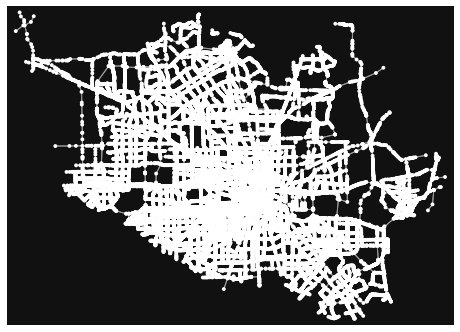

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [2]:
# Import mobility-related files
file_names = pd.read_csv(data_path.joinpath('traffic_data', 'file_names.txt'), header=None)
original_nodes = gpd.read_file(shp_path.joinpath('nodes.shp'))
merged_edge = utils.road_network_with_uncertainty(file_names, data_path)
G = utils.construct_network(merged_edge, original_nodes)
G = utils.remove_uncenessary_nodes(G)
ox.plot_graph(G)

In [3]:
# Load ICU bed availability data
xls_file = pd.read_csv(data_path.joinpath('hospital_availability.csv'))
xls_file = xls_file.loc[xls_file['County'] == f'Harris']
xls_file = xls_file.set_index('Date')

# Percentage of available ICU beds per day
avail_ICU = pd.DataFrame(index=xls_file.index, columns=['av_ICU'])
avail_ICU['av_ICU'] = xls_file.apply(lambda x: (x['Avail_ICU'] + x['COV_S_ICU'] + x['COV_C_ICU']) / 1614, axis=1)

# Calculate the percentage of how many percentage of ICU beds are available
probs = [i/10 for i in range(0, 11, 1)]
supply_prob = pd.DataFrame(index=['av_ratio'], columns=probs)
for idx, val in enumerate(probs):
    if idx == len(probs) - 1:
        break

    supply_prob.loc['av_ratio', probs[idx+1]] = avail_ICU.loc[(avail_ICU['av_ICU'] >= val) & (avail_ICU['av_ICU'] < probs[idx +1])].shape[0]
    supply_prob[val] = supply_prob[val].astype(float)

supply_prob = supply_prob / 153 # 153 days
supply_prob = supply_prob.drop(columns=[0.0])
supply_prob = supply_prob.round(decimals=2)  
supply_prob

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
av_ratio,0.0,0.17,0.38,0.23,0.21,0.01,0.0,0.0,0.0,0


<AxesSubplot:>

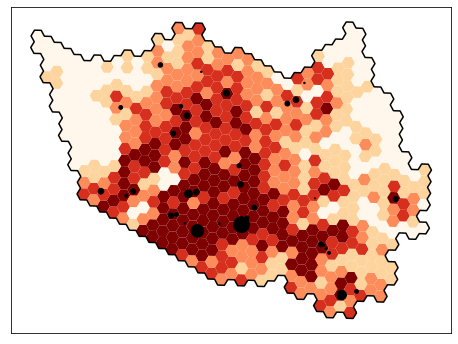

In [4]:
# Import supply (ICU beds) and demand (residential population)
supply = gpd.read_file(data_path.joinpath('supply_sample.shp'))
supply = supply.set_index('SupplyID')
supply = supply.loc[supply['ADULT_ICU_'] != 0]

demand = gpd.read_file(data_path.joinpath('demand_sample.shp'))
demand = demand.set_index('GRID_ID')
demand = demand.loc[demand['Note'] != 'water']

# Create study area for plotting
demand['dummy'] = 'dummy'
study_area = demand.dissolve(by='dummy')

# Plotting spatial distriubtions of residential population (demand) and ICU beds (supply)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

demand.plot('Pop', scheme='quantiles', cmap='OrRd', ax=ax)
study_area.boundary.plot(color='black', ax=ax)
supply.plot(ax=ax, color='black', markersize='NUM_ICU_BE')

In [5]:
# Find nearest node of OSM from supply and demand locations
supply = utils.find_nearest_osm(G, supply)
demand = utils.find_nearest_osm(G, demand)

100%|████████████████████████████████████████████████████████████████████████████████| 644/644 [00:26<00:00, 24.77it/s]


In [6]:
# Populate uncertainty of supply
supply = utils.supply_uncertainty(supply, supply_prob) 
supply[['HOSPITAL_N', 'HQ_ADDRESS', 'COUNTY_NAM', 'NUM_ICU_BE', 'Unc_cls', 'Unc_ICU']].head()

,HOSPITAL_N,HQ_ADDRESS,COUNTY_NAM,NUM_ICU_BE,Unc_cls,Unc_ICU
SupplyID,,,,,,
S009,TOPS Surgical Specialty Hospital,17080 Red Oak Dr,Harris,3.0,0.2,1.0
S011,Michael E DeBakey VA Medical Center,2002 Holcombe Blvd,Harris,2.0,0.2,0.0
S012,Houston Methodist Clear Lake Hospital (FKA Hou...,18300 Saint John Dr,Harris,14.0,0.3,4.0
S013,Memorial Hermann Northeast Hospital,18951 N Memorial Dr,Harris,24.0,0.4,10.0
S014,The Womans Hospital of Texas,7600 Fannin St,Harris,4.0,0.3,1.0


100%|█████████████████████████████████████████████████████████████████████████| 47260/47260 [00:04<00:00, 11666.94it/s]


Removed 1321 nodes (0.0288%) from the OSMNX network
Number of nodes: 45939
Number of edges: 70698


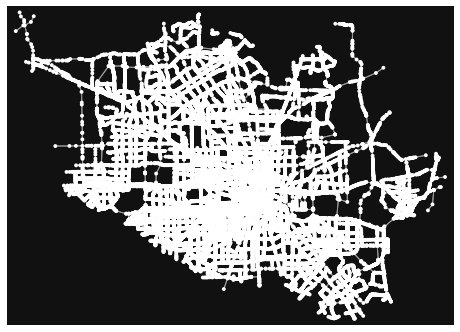

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
# Populate uncertainty of mobility
merged_edge = utils.road_network_with_uncertainty(file_names, data_path)
G = utils.construct_network(merged_edge, original_nodes)
G = utils.remove_uncenessary_nodes(G)
ox.plot_graph(G)

In [8]:
# Measuring spatial accessibility based on E2SFCA method
minutes = [10, 20, 30]
weights = {10: 1, 20: 0.68, 30: 0.22}

_supply = utils.E2SFCA_Step1(supply, demand, G, minutes, weights)
_demand = utils.E2SFCA_Step2(_supply, demand, G, minutes, weights)

100%|████████████████████████████████████████████████████████████████████████████████| 644/644 [04:53<00:00,  2.20it/s]


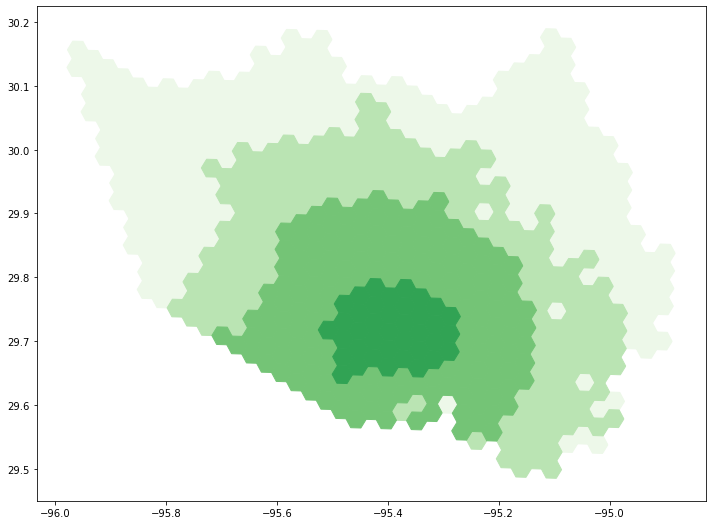

In [9]:
# Plotting the measures of spatial accessiblity
plt_cls = [0, 5, 10, 15, 20, 30]
colors = ['#edf8e9', '#bae4b3', '#74c476', '#31a354', '#006d2c']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

for idx, cls in enumerate(plt_cls):
    if idx == 0: continue
    temp_cls = _demand.loc[(plt_cls[idx-1] < _demand[f'step2']) & (_demand[f'step2'] <= cls)]
    if temp_cls.shape[0] > 0:
        temp_cls.plot(ax=ax, color=colors[idx-1], edgecolor=colors[idx-1])
        
plt.tight_layout()
plt.show()